In [11]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tools
import glob

In [12]:
top_dir = '/Users/emcmaho7/Dropbox/projects/SI_fmri/fmri'
data_dir = f'{top_dir}/input_data'
out_dir = f'{top_dir}/output_data'
figure_dir = f'{top_dir}/figures'

#### Plotting

In [3]:
def plot_ROI_results(df, outname, variable):
    features = df.Features.unique()
    n_features = len(features)
    roi = df.ROIs.unique()[0]

    #Set up figures
    sns.set(style='whitegrid', context='talk', rc={'figure.figsize':(6,5)})
    fig, ax = plt.subplots()

    colors = ['#48D4E1', '#8C55FD', '#FADC00']
    cmap = sns.color_palette(colors, as_cmap=True)
    g = sns.barplot(x='Features', y=variable,
                    data=df, ax=ax,
                    hue='Feature category',
                    palette=cmap,
                    dodge=False, ci=None)

    #Plot noise ceiling
    x = np.linspace(0, n_features, num=3)
    y1 = np.ones_like(x)*noise_ceiling.loc[noise_ceiling.ROIs == roi, variable].tolist()[0]
    ax.plot(x, y1, color='gray', alpha=0.5, linewidth=3)
    
    for ifeature, feature in enumerate(df.Features.unique()):
        x = ifeature
        sig = df.loc[df.Features == feature, 'group sig'].reset_index(drop=True)[0]
        p = df.loc[df.Features == feature, 'group_pcorrected'].reset_index(drop=True)[0]
        if sig:
            if p > 0.01:
                text = '*'
            elif p < 0.01 and p > 0.001:
                text = '**'
            elif p < 0.001:
                text = '***'
            ax.annotate(text, (x, 0.5), fontsize=20,
                        weight='bold', ha='center', color='gray')
            
        y1 = df[(df.Features == feature)].mean()['low sem']
        y2 = df[(df.Features == feature)].mean()['high sem']
        plt.plot([x, x], [y1, y2], 'black', linewidth=2)

    # #Aesthetics
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.set_xlabel('')
    ax.set_ylabel('Prediction accuracy ($\it{r}$)')
#     ax.tick_params(axis='y', labelsize=12)
    ax.set_ylim([-0.38, 0.58])
    sns.despine(left=True)
    handles, labels = ax.get_legend_handles_labels()
    plt.legend([],[], frameon=False)
    plt.tight_layout()
    if outname is not None:
        plt.savefig(outname)
        plt.close()
    else:
        plt.title(roi)

#### testing

In [13]:
rois = ['EVC', 'MT', 'EBA', 'PPA', 'TOS', 'RSC', 'LOC',  'FFA', 'OFA', '-STS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']
roi_names = ['EVC', 'MT', 'EBA', 'PPA', 'OPA', 'RSC', 'LOC',  'FFA', 'OFA', 'faceSTS', 'biomotion', 'SIpSTS', 'TPJ', 'DMPFC']

In [14]:
# Get the feature names for the annotated model
feature_categories = ['visual', 'visual', 'visual', 'visual', 'visual',
             'social detection', 'social detection', 
             'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation', 'social evaluation']
features = pd.read_csv(f'{data_dir}/annotations/annotations.csv').columns.to_list()
features.remove('video_name')

In [15]:
n_subjs = 4
n_features = len(features)

In [20]:
df = pd.DataFrame()
for sid_ in range(n_subjs):
    sid = str(sid_+1).zfill(2)
    pred = np.load(f'{out_dir}/voxelwise_encoding/sub-{sid}_rs.npy')
    for roi, name in zip(rois, roi_names):
        mask = glob.glob(f'{data_dir}/ROI_masks/sub-{sid}/*{roi}*nooverlap.nii.gz')
        masked, _ = tools.mask(pred.T, mask[0])
        for ifeature, (category, feature) in enumerate(zip(feature_categories, features)):
            r = masked[:,ifeature].mean()
            df = df.append({'Subjects': f'sub-{sid}',
                            'Features': feature,
                            'Feature category': category,
                            'ROIs': name, 
                            'Pearson r': r,
#                             'p value': p, 
#                             'low sem': r-r_var.std(), 
#                             'high sem': r+r_var.std(), 
                            'Explained variance': r ** 2},
                            ignore_index=True)

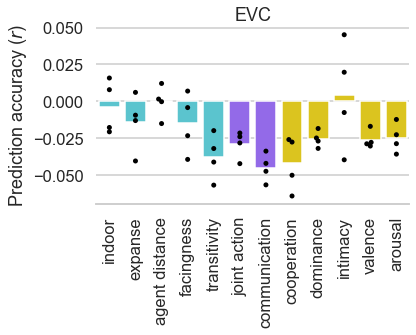

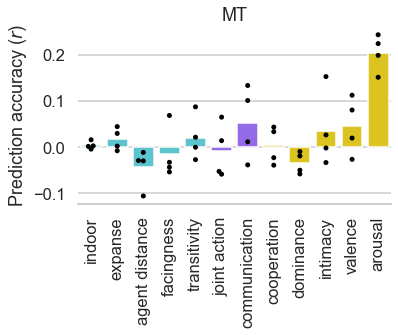

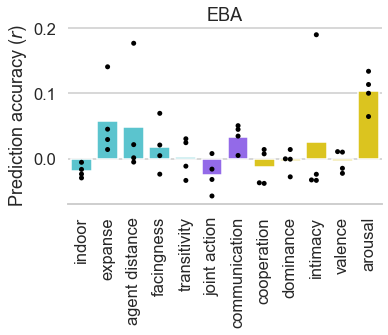

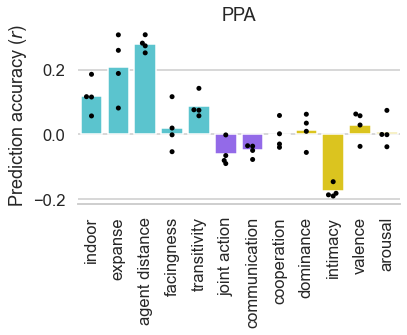

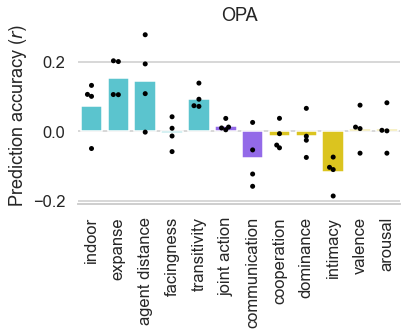

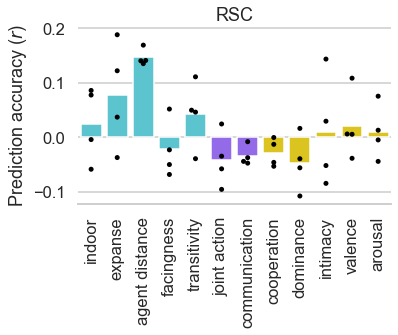

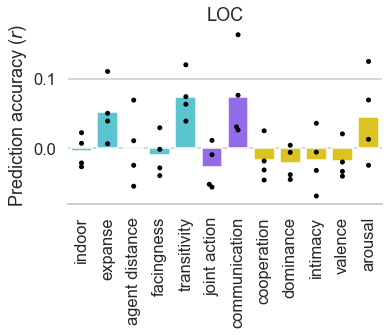

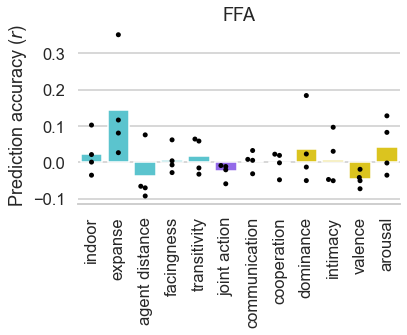

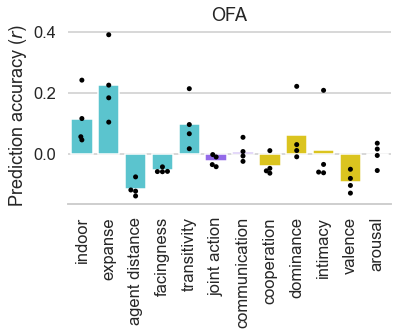

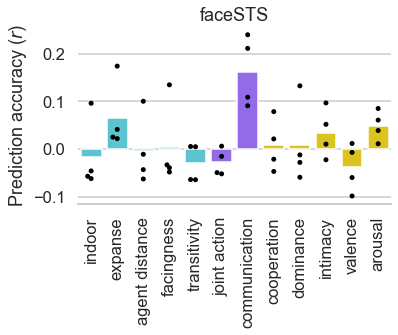

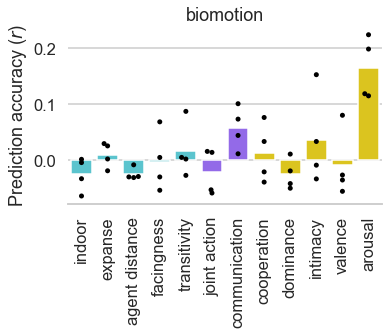

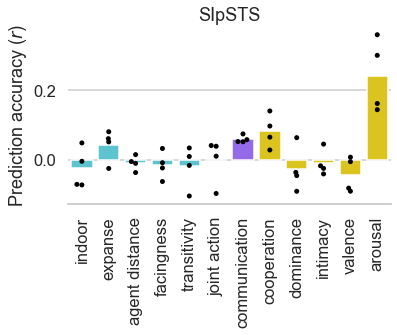

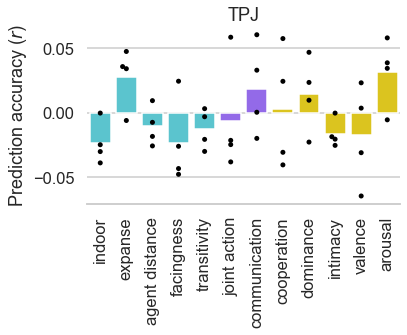

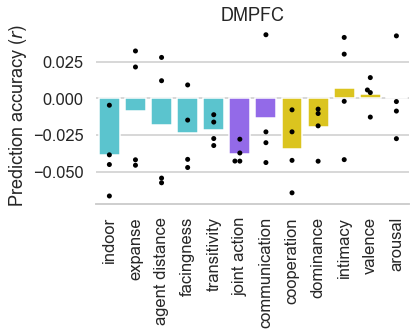

In [36]:
for roi in roi_names:
    cur = df.loc[df.ROIs == roi]
    colors = ['#48D4E1', '#8C55FD', '#FADC00']
    cmap = sns.color_palette(colors, as_cmap=True)
    sns.set(style='whitegrid', context='talk', rc={'figure.figsize':(6,5)})
    fig, ax = plt.subplots()
    sns.barplot(x='Features', y='Pearson r',
                data=cur, ax=ax,
                hue='Feature category',
                palette=cmap,
                dodge=False, ci=None)
    g = sns.swarmplot(x='Features', y='Pearson r',
                    data=cur, ax=ax,
                    color='black')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha='center')
    ax.get_legend().remove()
    plt.title(roi)
    sns.despine(left=True)
    ax.set_xlabel('')
    ax.set_ylabel('Prediction accuracy ($\it{r}$)')
    plt.tight_layout()
    plt.savefig(f'{figure_dir}/plot_encoding/{roi}.pdf')